<a href="https://colab.research.google.com/github/rbqpark/tinger/blob/main/TrainSNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Build and Train a Siamese Neural Network that calculates similarity constants between mel spectrograms.**

---

Model Research Links:

general idea: https://medium.com/@prabhnoor0212/siamese-network-keras-31a3a8f37d04steps-to-convert-audio-clip-to-spectrogram/comments 

https://www.pyimagesearch.com/2020/11/30/siamese-networks-with-keras-tensorflow-and-deep-learning/ 

pytorch example: https://innovationincubator.com/siamese-neural-network-with-pytorch-code-example/ 

siamese library: https://github.com/aspamers/siamese 

towardsdatascience: https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d

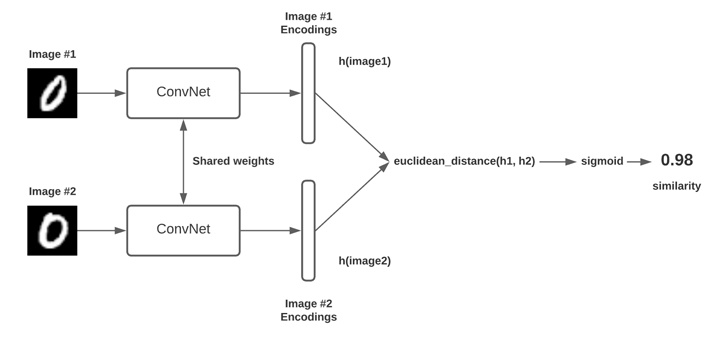

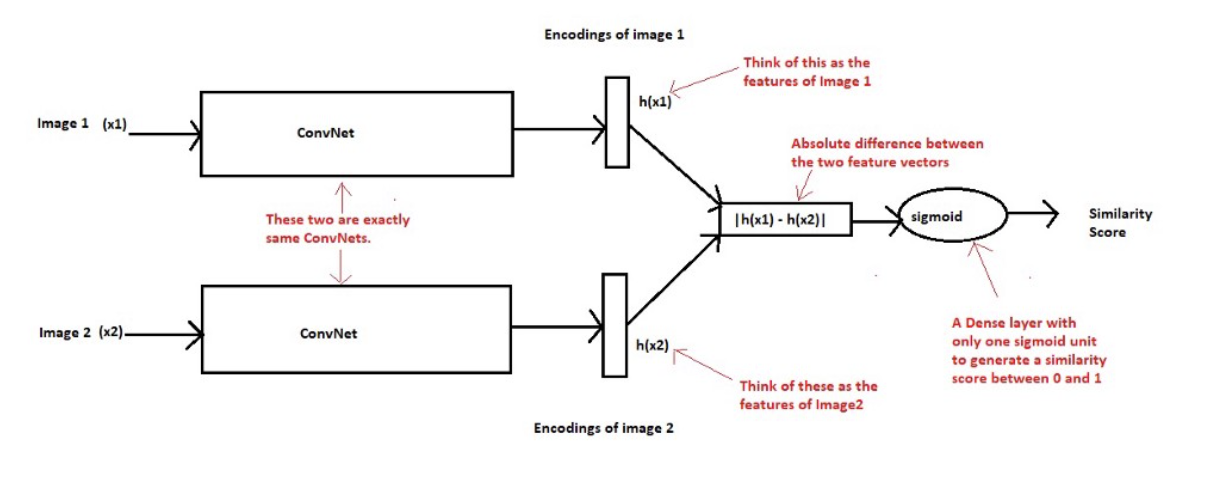

---
### **Mount Google Drive and install dependencies not local to the Colab environment**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install libraries not local to Colab
%pip install tensorflow
%pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 42kB/s 


---
### **Install rest of local dependencies and identify necessary filepaths**

In [ ]:
# Install all other dependencies
from tensorflow import keras
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, Dropout, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.regularizers import l2
from keras.initializers import GlorotNormal, HeNormal
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint


from keras.utils import plot_model
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.backend import clear_session

import pandas as pd
import numpy as np
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from timeit import default_timer

In [ ]:
# Identify path to mel spectrograms
mel_path = '/content/drive/My Drive/Tinger/Code/WAVtoShortMelSpectrogram-Output/Mel_Train/'

# Get list of all folders which are named by label
folder_list = os.listdir(mel_path)
print(len(folder_list), "labels in the training dataset")

27 labels in the training dataset


---
### **Load training and test (validation) data**

In [ ]:
# Load training and test data
train_test_split = 0.8
no_of_files_in_each_class = 10

# Declare training array
cat_list = []
x = []
y = []
y_label = 0

# Grab 10 spectrograms per label, then resize into 200 x 200 (originally 288 x 432)
for folder_name in folder_list:
    files_list = os.listdir(os.path.join(mel_path, folder_name))
    temp=[]
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x))
        to_append = np.asarray(Image.open(os.path.join(mel_path, folder_name, file_name)).convert('L').resize((200, 200)))
        x.append(to_append.reshape((200, 200, 1)))
        y.append(y_label)
    y_label+=1
    cat_list.append(temp)

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255.0
y = np.asarray(y)
print('X, Y shape',x.shape, y.shape, cat_list.shape)

X, Y shape (270, 200, 200, 1) (270,) (27, 10)


In [ ]:
# Training-validation split
train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'classes for training and', test_size, ' classes for validation')

train_files = train_size * no_of_files_in_each_class

# Training Split
x_train = x[:train_files]
y_train = y[:train_files]
cat_train = cat_list[:train_size]

# Validation Split
x_val = x[train_files:]
y_val = y[train_files:]
cat_test = cat_list[train_size:]

print('X,Y shape of training data :', x_train.shape, 'and', y_train.shape, cat_train.shape)
print('X,Y shape of validation data :' , x_val.shape, 'and', y_val.shape, cat_test.shape)


21 classes for training and 6  classes for validation
X,Y shape of training data : (210, 200, 200, 1) and (210,) (21, 10)
X,Y shape of validation data : (60, 200, 200, 1) and (60,) (6, 10)


---
### **Define all necessary functions to train a SNN. Create the SNN.**

In [ ]:
# Define a batch function to train SNN
# Adapted from an article by Krishna Prasad, a MS student from UMass-Amherst, now MLE at Walmart Labs
def get_batch(batch_size=32, call_type='train'):
    
  temp_x = None
  temp_cat_list = None
  start = None
  end = None
  batch_x = []
  
  if call_type == 'train':
      temp_x = x_train
      temp_cat_list = cat_train
      start=0
      end = train_size
  else:
      temp_x = x_val
      temp_cat_list = cat_test
      start = train_size+1
      end = len(folder_list)-1
      
  batch_y = np.zeros(batch_size)
  batch_y[int(batch_size/2):] = 1
  np.random.shuffle(batch_y)
  
  class_list = np.random.randint(start, end, batch_size)
  batch_x.append(np.zeros((batch_size, 200, 200, 1)))
  batch_x.append(np.zeros((batch_size, 200, 200, 1)))

  for i in range(batch_size):
      batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]  

      if batch_y[i] == 0:
          batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]

      else:
          temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
          batch_x[1][i] = temp_x[np.random.choice(temp_list)][np.random.choice(np.arange(10))]
          
  return(batch_x, batch_y)

In [ ]:
# Create siamese neural network based on input shape (of mel spectrogram)
init_G = keras.initializers.GlorotNormal()
init_H = keras.initializers.HeNormal()

input_shape = (200, 200, 1)
older_input = Input(input_shape)
younger_input = Input(input_shape)

# Convolutional neural network architecture
model = Sequential()

model.add(Conv2D(128, (10,10), activation='relu', input_shape=input_shape, kernel_initializer=init_H, kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.001))

model.add(Conv2D(128, (10,10), activation='relu', kernel_initializer=init_H, kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.001))

model.add(Conv2D(64, (4,4), activation='relu', kernel_initializer=init_H, kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Dropout(rate=0.001))

model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(2048, activation='sigmoid', kernel_initializer=init_G, kernel_regularizer=l2(1e-3)))

# Generate feature vectors
feature_older = model(older_input)
feature_younger = model(younger_input)

# Calculate absolute difference between feature vectors (alternative to Subtract layer)
L1_layer = Lambda(lambda tensors:keras.backend.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([feature_older, feature_younger])

# Add a dense layer with a sigmoid unit to generate the similarity score
prediction = Dense(1,activation='sigmoid',kernel_initializer=init_G)(L1_distance)

# Connect the inputs with the outputs
snn = Model(inputs=[older_input,younger_input],outputs=prediction)

In [ ]:
# Add optimizer and compile
optimizer = Adam(lr = 0.0001)
snn.compile(loss='binary_crossentropy',optimizer=optimizer)

# Set a checkpoint to enable re-loading of partially trained model
filepath = 'snn.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

snn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         1915712     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 2048)         0           sequential[0][0]             

In [ ]:
# Define an n-way one-short validation function
# Adapted from same article by Krishna Prasad
def nway_one_shot(model, n_way, n_val):
  temp_x = x_val
  temp_cat_list = cat_test
  batch_x = []
  x_0_choice = []
  n_correct = 0
  n_above5 = 0
  n_above10 = 0
  
  class_list = np.random.randint(train_size+1, len(folder_list)-1, n_val)

  for i in class_list:  
      j = np.random.choice(cat_list[i])
      temp = []
      temp.append(np.zeros((n_way, 200, 200, 1)))
      temp.append(np.zeros((n_way, 200, 200, 1)))
      for k in range(0, n_way):
          temp[0][k] = x[j]
          
          if k==0:
              temp[1][k] = x[np.random.choice(cat_list[i])]
          else:
              temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten()))]

      result = snn.predict(temp)
      result = result.flatten().tolist()
      result_index = result.index(min(result))

      if result_index == 0:
          n_correct += 1
      if result_index <= 5:
          n_above5 += 1
      if result_index <= 10:
          n_above10 += 1

  print(n_correct, 'correctly classified among', n_val)
  print(n_above5, 'correctly classified in top 5 among', n_val)
  print(n_above10, 'correctly classified in top 10 among', n_val)
  accuracy = (n_correct*100)/n_val
  above5 = (n_above5*100)/n_val
  above10 = (n_above10*100)/n_val
  return [accuracy, above5, above10]

Below is an example of a 4-way validation process, where one would assume that the first pair of images (label=0) has a higher similarity score than the other three (label=1). This is our chosen method of calculating model accuracy, which is also a popular industry standard.

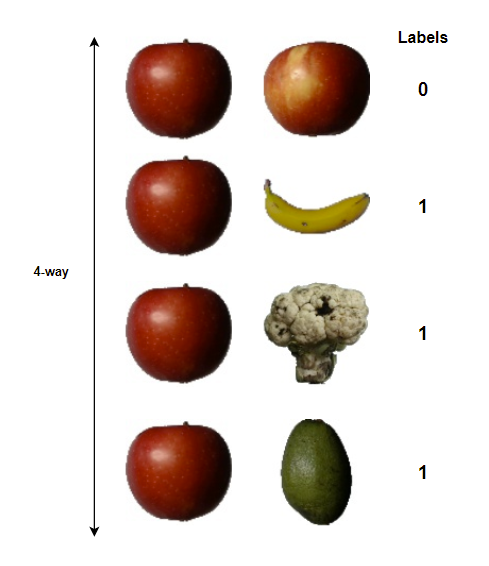

---
### **Create lists to save performance measures. Train the model, then save it into our Tinger Google Drive database.**

In [ ]:
# Save loss, accuracy, and above5-accuracy lists for future use
loss_list = []
accuracy_list = []
above5_list = []
above10_list = []

In [ ]:
# Training based on four hyperparameters: epoch, n_way, n_val, and batch size.
# n_way refers to the number of 'ways' for each validation trial (in the example above, n_way=4)
# n_val refers to the number of validation trials
epochs = 10000
n_way = 50
n_val = 100
batch_size = 32

for epoch in range(1,epochs):
  start_time = default_timer()
  batch_x, batch_y = get_batch(batch_size, call_type='train')
  loss = snn.train_on_batch(batch_x, batch_y)
  loss_list.append((epoch,loss))
  print('Epoch:', epoch, ', Loss:', loss)
  if epoch%100 == 0:
    print('=============================================')
    accuracy = nway_one_shot(model, n_way, n_val)
    accuracy_list.append((epoch, accuracy[0]))
    above5_list.append((epoch, accuracy[1]))
    above10_list.append((epoch, accuracy[2]))
    print('Accuracy as of', epoch, 'epochs:', accuracy[0])
    print('Above5-Accuracy as of', epoch, 'epochs:', accuracy[1])
    print('Above10-Accuracy as of', epoch, 'epochs:', accuracy[2])
    print('=============================================')
  end_time = default_timer()
  print('Elapsed training time: {0}s'.format(end_time-start_time))
  

In [ ]:
model_path = '/content/drive/My Drive/Tinger/Code/'

snn.save(model_path)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Tinger/Code/assets


---
### **[Optional] Plot Above5 accuracy and validation loss graphs.**

In [ ]:
# Plot Above5 Accuracy
above5_x, above5_y = map(list, zip(*above5_list))
mean_above5 = np.mean(above5_y)
median_above5 = np.median(above5_y)

plt.figure(figsize=(20,10))
plt.plot(above5_x, above5_y, label='Validation Accuracy')
plt.hlines(y=mean_above5, xmin=0, xmax=10000, label='Mean ({}/100)'.format(round(mean_above5,2)), colors='orange')
plt.hlines(y=median_above5, xmin=0, xmax=10000, label='Median ({}/100)'.format(median_above5), colors='green')
plt.legend(fontsize="x-large");

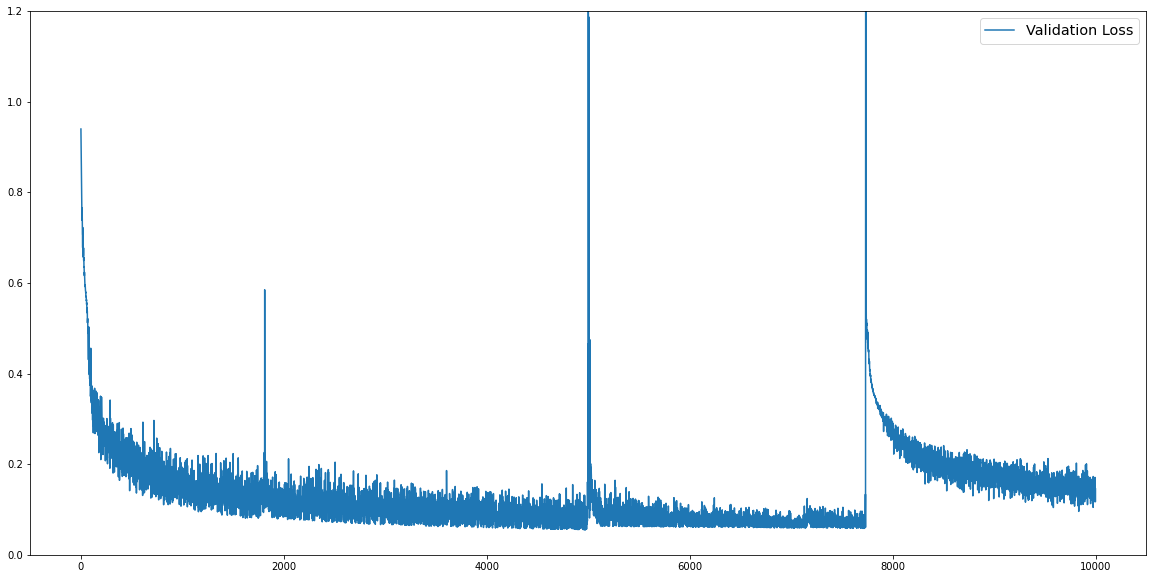

In [ ]:
# Plot Validation Loss (Small)
loss_x, loss_y = map(list, zip(*loss_list))

plt.figure(figsize=(20,10))
plt.ylim((0,1.2))
plt.plot(loss_x, loss_y, label='Validation Loss')
plt.legend(loc=1, fontsize="x-large");